In [1]:
import os
import glob
import shutil
import math

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns


In [2]:
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [3]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def label_figure(fig, data_identifier):                                                                                                                                     
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)    

In [4]:
%matplotlib notebook

# Set source dirs

In [5]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

In [6]:
outdir = os.path.join(aggregate_dir, 'luminance-analysis')
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [7]:
if not os.path.exists(os.path.join(outdir, 'roi-luminance-arrays')):
    os.makedirs(os.path.join(outdir, 'roi-luminance-arrays'))

# Get aggregate data

In [8]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)


/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

# Select datasets with RFs + blobs

In [9]:
include_sessions = []
included_ixs = []
for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
    if any(['rf' in v for v in g['experiment'].values]) and 'blobs' in g['experiment'].values:
        include_sessions.append((animalid, session, fov))
        included_ixs.extend(g.index.tolist())
        
dsets = sdata.loc[included_ixs]
fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
dsets['fovnum'] = fovnums

print(dsets.shape)

(137, 6)


# Get counts per area

In [10]:
dsets[dsets['experiment']=='blobs'].groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,13,13,13,13,13
Lm,12,12,12,12,12
V1,11,11,11,11,11


In [11]:
dsets[dsets['experiment'].isin(['rfs', 'rfs10'])].groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,14,14,14,14,14
Lm,12,12,12,12,12
V1,15,15,15,15,15


In [12]:
# incl_sessions = ['20190522', '20191006', '20190616',
#                  '20190609', '20190614', '20191018']

# dsets = dsets[dsets['session'].isin(incl_sessions)]


In [13]:
#dsets.groupby(['visual_area']).count()


# Load data

In [29]:
def get_trial_stats(animalid, session, fovnum, curr_exp='blobs',
                                   traceid='traces001', response_type='dff',
                                   responsive_test='ROC', responsive_thr=0.05, n_stds=0.):
    print(animalid, session, curr_exp)
    # Load experiment neural data
    fov = 'FOV%i_zoom2p0x' % fovnum
    if curr_exp == 'blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid)
    elif curr_exp == 'gratings':
        exp = util.Gratings(animalid, session, fov, traceid=traceid)
    else:
        print("DUNNO WHAT TO LOAD.")
        
    exp.load(trace_type='dff', update_self=True, make_equal=True)
    labels = exp.data.labels.copy()

    # Get stimulus config info
    sdf = exp.data.sdf
    sdf = reformat_morph_values(sdf)
    n_conditions = len(sdf['size'].unique())
    color_list = sns.color_palette('cubehelix', n_conditions)
    cond_colors = dict((k, color_list[i]) for i, k in enumerate(sorted(sdf['size'].unique()))) #.keys()))

    # ----- PUPIL/FACE STUFF -------------------------------
    # Add stimulus config info to face data
    trial_key = pd.DataFrame({'config': [g['config'].unique()[0] \
                             for trial, g in labels.groupby(['trial'])],
                  'trial': [int(trial[5:]) \
                             for trial, g in labels.groupby(['trial'])]})
    trial_key.index = trial_key['trial']

    # ----- NEURAL STUFF -------------------------------

    # Get responsive cells
    responsive_cells, ncells_total = exp.get_responsive_cells(response_type=response_type,\
                                                              responsive_test=responsive_test, 
                                                              responsive_thr=responsive_thr,
                                                              n_stds=n_stds)
    
    # Get nrois x ntrials array
    roi_responses = pd.DataFrame(np.vstack([np.nanmean(exp.data.traces.iloc[g.index], axis=0)\
                                        for trial, g in labels.groupby(['trial'])]),
                                index=[int(trial[5:]) for trial, g in labels.groupby(['trial'])])

    print("%i out of %i cells pass responsive test." % (len(responsive_cells), ncells_total))
    neuraldata = roi_responses[responsive_cells]

    return neuraldata, trial_key, sdf
    

In [16]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


# Stim reformatiting functions

In [17]:
import cv2
def resize_image_to_coords(im, size_deg=30, pix_per_deg=10.01, aspect_scale=1.747):
    print(pix_per_deg)
    ref_dim = max(im.shape)
    resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    scale_factor = resize_factor * aspect_scale
    
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)
    
    return imr

In [18]:
def resize_image_to_screen(im, size_deg=30, pix_per_deg=16.06, aspect_scale=1.747):
    ref_dim = max(im.shape)
    #resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    #print(resize_factor)
    #scale_factor = resize_factor * aspect_scale
    scale_factor = (size_deg*aspect_scale)/(1./pix_per_degW) / ref_dim
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)

    return imr

In [19]:
def convert_range(oldval, newmin=None, newmax=None, oldmin=None, oldmax=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

# RF calculation functions

In [20]:
def update_rfparams(rfparams):

    screen_pix_x, screen_pix_y = rfparams['screen_resolution']
    screen_xmin_deg, screen_xmax_deg = rfparams['screen_xlim_deg']
    screen_ymin_deg, screen_ymax_deg = rfparams['screen_ylim_deg']
    stim_xpos, stim_ypos = rfparams['stim_pos']
    
    # Convert specified stim position to pixel space
    stim_xpos_pix = convert_range(stim_xpos, newmin=0, newmax=screen_pix_x, 
                                  oldmin=screen_xmin_deg, oldmax=screen_xmax_deg)
    stim_ypos_pix = convert_range(stim_ypos, newmin=0, newmax=screen_pix_y, 
                                  oldmin=screen_ymin_deg, oldmax=screen_ymax_deg)

    # Create "screen" array to project image onto
    stim_xpos_pix = int(round(stim_xpos_pix))
    stim_ypos_pix = int(round(stim_ypos_pix))
    #print(stim_xpos_pix, stim_ypos_pix)

    row_vals_pix = [convert_range(rv, newmin=0, newmax=screen_pix_y, 
                    oldmin=screen_ymin_deg, oldmax=screen_ymax_deg) for rv in rfparams['row_vals']]

    col_vals_pix = [convert_range(cv, newmin=0, newmax=screen_pix_x, 
                    oldmin=screen_xmin_deg, oldmax=screen_xmax_deg) for cv in rfparams['col_vals']]

    converted = {'stim_pos_pix': (stim_xpos_pix, stim_ypos_pix),
                 'row_vals_pix': row_vals_pix, 
                 'col_vals_pix': col_vals_pix}
    
    rfparams.update(converted)
    
    return rfparams


def transform_rfmap(rfmap, rfparams, pix_per_deg=16.05):

    # Normalize rf map to range bw (0, 1)
    normed_rfmap = rfmap/rfmap.max()

    # Resize RF map to match image array
    rfsize = int(np.ceil(pix_per_deg * rfparams['spacing']))
    #print("rf tile size:", rfsize)

    # Create RF map array
    screen_x, screen_y = rfparams['screen_resolution']
    rfscreen = np.ones((screen_y, screen_x))
    for rii, ri in enumerate(rfparams['row_vals_pix']):
        for cii, ci in enumerate(rfparams['col_vals_pix']):
            r_ix = int(round(ri-(rfsize/2.)))
            c_ix = int(round(ci-(rfsize/2.)))
            #print(r_ix, c_ix)
            rfscreen[r_ix:r_ix+rfsize, c_ix:c_ix+rfsize] = normed_rfmap[rii, cii]

    return rfscreen

In [259]:

def transform_stim_image(curr_img, rfparams, size_deg=30., pix_per_deg=16.05, verbose=False):
    
    screen_pix_x, screen_pix_y = rfparams['screen_resolution']
    stim_xpos_pix, stim_ypos_pix = rfparams['stim_pos_pix']
    
    # Resize image (specify pixels based on selected size in degrees)
    imr_pix = resize_image_to_screen(curr_img, size_deg=size_deg, pix_per_deg=pix_per_deg) #, aspect_scale=1.747)

    # Pad resized image to match rf screen
    x_pad2 = round(screen_pix_x - (stim_xpos_pix + imr_pix.shape[1]/2.)) # Get far right edge
    x_pad1 = round(stim_xpos_pix - (imr_pix.shape[1]/2.)) # Get left edge
    y_pad1 = round(screen_pix_y - (stim_ypos_pix + imr_pix.shape[0]/2.)) # Get top edge
    y_pad2 = round(stim_ypos_pix - (imr_pix.shape[0]/2.)) # Get bottom edge

    imscreen = np.pad(imr_pix, (( int(abs(y_pad1)), int(abs(y_pad2)) ), \
                                ( int(abs(x_pad1)), int(abs(x_pad2)) )), mode='constant', constant_values=0)
    #print(size_deg, imscreen.shape)

    # Check if image is blown up beyond array size
    if x_pad2 < 0:     # need to trim right edge:
        imscreen = imscreen[:, 0:screen_pix_x]
        if verbose:
            print("...overblown on right edge", imscreen.shape)
    elif x_pad1 < 0:   # need to trim left edge
        trim_left = screen_pix_x - imscreen.shape[1]
        imscreen = imscreen[:, trim_left:]
        print("...overblown on left edge", imscreen.shape)

    if y_pad2 < 0:     # need to trim bottom edge:
        imscreen = imscreen[0:screen_pix_y, :]
        if verbose:
            print("...overblown on bottom edge", imscreen.shape)
    elif y_pad1 < 0:   # need to trim top edge
        trim_top = screen_pix_y - imscreen.shape[0]
        imscreen = imscreen[trim_top:, :]
        if verbose:
            print("...overblown on top edge", imscreen.shape)

    # Check if need extra padding:
    if imscreen.shape[0] < screen_pix_y:
        n_pad_extra = screen_pix_y - imscreen.shape[0]
        imscreen = np.pad(im_screen, ((0, n_pad_extra), (0, 0)), mode='constant', constant_value=0)
        if verbose:
            print("...padding %i to bottom" % n_pad_extra, imscreen.shape)
    elif imscreen.shape[0] > screen_pix_y:
        imscreen = imscreen[0:screen_pix_y, :]
        if verbose:
            print("...trimming %i off bottom" % (imscreen.shape[0]-screen_pix_y), imscreen.shape)

    if imscreen.shape[1] < screen_pix_x:
        n_pad_extra = screen_pix_x - imscreen.shape[1]
        imscreen = np.pad(im_screen, ((0, 0), (0, n_pad_extra)), mode='constant', constant_value=0)
        if verbose:
            print("...padding %i to right" % n_pad_extra, imscreen.shape)
    elif imscreen.shape[1] > screen_pix_x:
        imscreen = imscreen[:, 0:screen_pix_x]
        if verbose:
            print("...trimming %i off right" % (imscreen.shape[1]-screen_pix_x), imscreen.shape)

    return imscreen


In [22]:
def get_rfparams(screen_info, rfstats):
    rfparams = {'screen_xlim_deg': (screen_info['linminW'], screen_info['linmaxW']),
            'screen_ylim_deg': (screen_info['linminH'], screen_info['linmaxH']),
            'screen_resolution': tuple(screen_info['resolution']),
            'col_vals': rfstats['col_vals'],
            'row_vals': rfstats['row_vals'],
            'spacing': np.diff(rfstats['row_vals']).mean(),\
            'stim_pos': tuple(screen_info['stim_pos'])}
    rfparams = update_rfparams(rfparams)
    
    return rfparams

In [23]:
def plot_luminance_calculation(imarray, rfarray, lumarray, rfparams,
                               rf_cmap='hot', lum_cmap='jet'):
    
    fig, axes = pl.subplots(1, 3, figsize=(15,3))

    axes[0].imshow(imarray, origin='bottom', alpha=1, cmap='gray')
    axes[1].imshow(rfarray, origin='bottom', alpha=1, cmap=rf_cmap)
    axes[2].imshow(lumarray, origin='bottom', alpha=1, cmap=lum_cmap)

    for ax in axes:

        # Draw cells for RF tiling boundaries
        for rv in rfparams['col_vals_pix']:
            ax.axvline(rv - pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)
        ax.axvline(rv + pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)
        for rv in rfparams['row_vals_pix']:
            ax.axhline(rv - pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)
        ax.axhline(rv + pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)

        # Label coordinates
        ax.set_xticks(rfparams['col_vals_pix'])
        ax.set_xticklabels([int(i) for i in rfparams['col_vals']], fontsize=6)

        ax.set_yticks(rfparams['row_vals_pix'])
        ax.set_yticklabels([int(i) for i in rfparams['row_vals']], fontsize=6)
        
    return fig

#  Load stimulus images

In [24]:
# Get image paths:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'
#sdf = DATA[datakey]['sdf']
#morph_levels = [m for m in sdf['morphlevel'].unique() if m != -1]
object_list = ['D1', 'M14', 'M27', 'M40', 'M53', 'M66', 'M79', 'M92', 'D2']
#object_list = ['D1', 'D2']

image_paths = []
for obj in object_list:
    stimulus_type = 'Blob_%s_Rot_y_fine' % obj
    image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
print("%i images found for %i objects" % (len(image_paths), len(object_list)))

images = {}
for object_name, impath in zip(object_list, image_paths):
    im = cv2.imread(impath)
    if object_name == 'D1':
        object_name = 'M0'
    if object_name == 'D2':
        object_name = 'M106'
    images[object_name] = im[:, :, 0]
print("im shape:", images['M0'].shape)
image_list = sorted(images.keys(), key=natural_keys)


9 images found for 9 objects
('im shape:', (618, 1080))


In [501]:
rfparams['screen_resolution']

(1920, 1080)

# Load object data

In [25]:
curr_exp = 'blobs'

responsive_test = 'ROC'
responsive_thr = 0.05
traceid = 'traces001'

exclude_sessions = ['JC078_20190426']

In [26]:
load_data = False
data_outfile = os.path.join(outdir, 'blobs_%s-%s-%.2f.pkl' % (response_type, responsive_test, responsive_thr))
if os.path.exists(data_outfile):
    with open(data_outfile, 'rb') as f:
        DATA = pkl.load(f)
else:
    load_data = True
    

In [27]:
load_data=True
del DATA

In [30]:
if load_data:
    DATA = {}
    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        if '_'.join([animalid, session]) in exclude_sessions:
            continue
 
        #datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, curr_exp) 
        datakey ='%s_%s_fov%i' % (session, animalid, fovnum) 

        neuraldata, trial_key, sdf = get_trial_stats(animalid, session, fovnum, 'blobs',
                                                           traceid='traces001', response_type=response_type,
                                                           responsive_test='ROC', responsive_thr=0.05)

        DATA[datakey] = {'data': neuraldata,
                         'trial_key': trial_key,
                         'sdf': sdf}
    
    print("... saving extracted and formatted data...")
    print(data_outfile)
    with open(data_outfile, 'wb') as f:
        pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)


('JC076', '20190502', 'blobs')
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/data_arrays/np_subtracted.npz
NP_subtracted offset was: 187.55
adding NP offset... (NP baseline offset: 797.67)
((245946, 226), (226,), ())
... adjusting for equal reps / condn...
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/summary_stats/ROC/roc_results.pkl']
60 out of 226 cells pass responsive test.
('JC090', '20190605', 'blobs')
... [JC090|20190605|

adding NP offset... (NP baseline offset: 785.43)
((201000, 269), (269,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d86de1_traces001_8df9ce_traces001_61ca30_traces001_0266b8_traces001_111679_traces001_0abebe/summary_stats/ROC/roc_results.pkl']
64 out of 269 cells pass responsive test.
('JC099', '20190617', 'blobs')
... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/data_arrays/np_subtracted.npz
NP_subtracted offset was: 3.88
adding NP offset... (NP baseline offset: 854.19)
((131355, 102), (102,), ())
... adjusting for equal reps / condn...
... updati

NP_subtracted offset was: 93.07
adding NP offset... (NP baseline offset: 624.21)
((259550, 285), (285,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8a95b0_traces001_ba1965_traces001_f4a730_traces001_77eafa_traces001_78a718_traces001_e4c65e/summary_stats/ROC/roc_results.pkl']
146 out of 285 cells pass responsive test.
('JC080', '20190603', 'blobs')
... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_e17055_traces001_dd9e99_traces001_841aa9_traces001_d4242f_traces001_7b3713_traces001_d4ccf3/data_arrays/np_subtracted.npz
NP_subtracted offset was: 78.51
adding NP offset... (NP baseline offset: 773.60)
((201000, 

NP_subtracted offset was: 77.17
adding NP offset... (NP baseline offset: 413.01)
((268500, 182), (182,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/summary_stats/ROC/roc_results.pkl']
96 out of 182 cells pass responsive test.
('JC083', '20190510', 'blobs')
... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/np_subtracted.npz
NP_subtracted offset was: 60.57
adding NP offset... (NP baseline offset: 42

In [32]:
# # SAVE
# data_outfile = os.path.join(outdir, 'blobs_%s-%s-%.2f.pkl' % (response_type, responsive_test, responsive_thr))
# print(data_outfile)
# with open(data_outfile, 'wb') as f:
#     pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
        

# Test with 1 dataset

In [33]:
session = '20190606'
animalid = 'JC091'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey ='%s_%s_fov%i' % (session, animalid, fovnum)  
print(datakey)


20190606_JC091_fov1


## Load session to get condition info

In [34]:
S = util.Session(animalid, session, fov, rootdir=rootdir)

# Get screen bounds: [bottom left upper right]
screen_bounds = [S.screen['linminH'], S.screen['linminW'], S.screen['linmaxH'], S.screen['linmaxW']]
screen_aspect = S.screen['resolution'][0] / S.screen['resolution'][1]

screen_width_deg = S.screen['linmaxW']*2
screen_height_deg = S.screen['linmaxH']*2

pix_per_degW = S.screen['resolution'][0] / screen_width_deg
pix_per_degH = S.screen['resolution'][1] / screen_height_deg 

print(pix_per_degW, pix_per_degH)
pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
print("avg pix/deg: %.2f" % pix_per_deg)

stim_xpos, stim_ypos = S.get_stimulus_coordinates()

screen_info = S.screen.copy()
screen_info['stim_pos'] = (stim_xpos, stim_ypos)

[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
(16.059366123436302, 16.042065861592622)
avg pix/deg: 16.05
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190606|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)


## Load RFs and get shared roi list

In [35]:
# Blob trial metrics
neuraldata = DATA['%s' % datakey]['data'].copy()
trial_key = DATA['%s' % datakey]['trial_key'].copy()
blobstats = pd.concat([neuraldata, trial_key], axis=1)
blobstats.index = blobstats['trial']
blobstats.drop('trial', axis=1, inplace=True)
sdf = DATA[datakey]['sdf']

# ROI list for objects
rois_objects = np.array(DATA['%s' % datakey]['data'].columns.tolist())
sizes = sorted(DATA['%s' % datakey]['sdf']['size'].unique())

# RF fit data
g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

# Get ROIs for both
print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
roi_list = np.intersect1d(rois_objects, rois_rfs)
print("%i rois common to both." % len(roi_list))

# Get RF/screen param info
rfparams = get_rfparams(screen_info, rfstats)

... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 110, RFs: 65
25 rois common to both.


In [61]:
# Blob trial metrics
neuraldata = DATA['%s' % datakey]['data'].copy()
print(neuraldata.shape)
trial_key = DATA['%s' % datakey]['trial_key'].copy()
blobstats = pd.concat([neuraldata, trial_key], axis=1)

(1600, 110)


In [66]:
trial_key.head()

,config,trial
0,config020,1
1,config016,2
2,config044,3
3,config001,4
4,config046,5


In [68]:
pd.concat([neuraldata, trial_key], axis=1).reset_index(drop=True).shape

(1626, 112)

## Calculate RF stimulus metrics

#### Resize image to specified degrees, map to screen coordinates
1. Get screen size in pixels and degrees (pix_per_deg)
2. Calculate resize factor for image in pixels, based on specified size + position (degrees), and known screen res
3. Resize image and pad to position it correctly in pixel space of screen
4. Get RF map in screen coords (pixels)
5. Plot overay

In [37]:
data_id = '%s|%s-%s_%s-%.2f' % (datakey, traceid, response_type, responsive_test, responsive_thr)
print(data_id)

20190606_JC091_fov1|traces001-dff_ROC-0.05


In [38]:
rf_cmap = 'hot'
lum_cmap = 'jet'
plot_roi = False

In [379]:
def get_rf_luminances(images, rfstats, rfparams, roi_list=None, pix_per_deg=16.05, sizes=np.array([10, 20, 30, 40, 50])):

    if roi_list is None:
        roi_list = rfstats['fit_results'].keys()
    image_list = sorted(images.keys(), key=natural_keys)
    rfdf = []
    
    for curr_object in image_list:
        for size_deg in sizes:
            # Transform stimulus image
            curr_img = images[curr_object]
            imscreen = transform_stim_image(curr_img, rfparams, size_deg=size_deg, pix_per_deg=pix_per_deg)

            # Get arrays in correct orientation for multiplying
            imarray = np.flipud(imscreen).copy()
    
            for rid in roi_list:

                # Transform rfmap to screen
                rfmap = rfstats['fit_results'][rid]['data']
                rfscreen = transform_rfmap(rfmap, rfparams)
                rfarray = rfscreen.copy()
                lumarray = imarray * rfarray

                # Calculate max possible luminance
                max_brightness = np.ones(imarray.shape)*255.
                max_lum = max_brightness.ravel().dot(rfarray.ravel())

                # Express RF luminance as fraction of RF max brightness
                fraction_lum = lumarray.sum() / max_lum

                rdf = pd.DataFrame({'object': curr_object,
                                    'size': size_deg,
                                    'RF_luminance': fraction_lum,
                                    'rid': rid}, index=[rid])
                rfdf.append(rdf)

#                 if plot_roi and size_deg in [30] and curr_object in ['M0', 'M106']:
#                     fig = plot_luminance_calculation(imarray, rfarray, lumarray, rfparams,
#                                                      rf_cmap=rf_cmap, lum_cmap=lum_cmap)

#                     pl.suptitle('roi %i (%.2f)' % (int(rid+1), fraction_lum))
#                     label_figure(fig, data_id)

#                     figname = 'roi%05d_sz%i_%s' % (int(rid+1), size_deg, curr_object) 
#                     curr_outdir = os.path.join(outdir, 'roi-luminance-arrays', datakey)
#                     if not os.path.exists(curr_outdir):
#                         os.makedirs(curr_outdir)
#                     pl.savefig(os.path.join(curr_outdir, '%s.svg' % figname))
#                     print(figname)
#                     pl.close()

    rfdf = pd.concat(rfdf, axis=0)
    return rfdf

In [269]:
#rfdf.groupby(['rid']).count()

In [163]:
# if plot_roi:
#     fig = plot_luminance_calculation(imarray, rfarray, lumarray, rfparams,
#                                      rf_cmap=rf_cmap, lum_cmap=lum_cmap)

#     pl.suptitle('roi %i (%.2f)' % (int(rid+1), fraction_lum))
#     label_figure(fig, data_id)

#     figname = 'roi%05d_%s_sz%i' % (int(rid+1), curr_object, size_deg) 
#     pl.savefig(os.path.join(outdir, 'roi-luminance-arrays', '%s.svg' % figname))
#     print(figname)
    
#     pl.close()


In [44]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.cm as cm

def create_color_bar(fig, hue_colors, hue_values, hue_param='label', #cmap='cube_helix', 
                     orientation='horizontal', cbar_axes=[0.58, 0.17, 0.3, 0.02]):

    cmap = ListedColormap(hue_colors)
    bounds = np.arange(0, len(hue_values))
    norm = BoundaryNorm(bounds, cmap.N)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(bounds)

    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(mappable, cax=cbar_ax, boundaries=np.arange(-0.5,len(hue_values),1), \
                        ticks=bounds, norm=norm, orientation='horizontal')
    cbar.ax.tick_params(axis='both', which='both',length=0)
    cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar
    cbar.ax.set_xlabel(hue_param, fontsize=12)

    return cbar

In [45]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


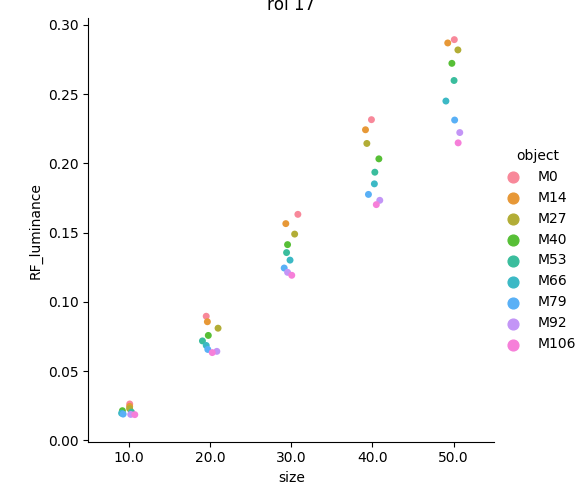

In [46]:
rid = roi_list[0]
tmpdf = rfdf[rfdf['rid']==rid]

sns.catplot(x='size', y='RF_luminance', hue='object', data=tmpdf)
pl.title('roi %i' % int(rid+1))

pl.savefig(os.path.join(outdir, 'roi-plot-RF-luminance', '%s_roi%05d.svg' % (datakey, int(rid+1))))

In [47]:
morph_cmap = 'coolwarm'
#morph_colors = sns.color_palette('cubehelix', len(image_list))
morphcolor_list = sns.color_palette(morph_cmap, len(image_list))
morph_colors = dict((morph, c) for morph, c in zip(image_list, morphcolor_list))

In [48]:
data_id

'20190606_JC091_fov1|traces001-dff_ROC-0.05'

In [49]:
morphlevels = sorted(sdf['morphlevel'].unique())
sizes = sorted(sdf['size'].unique())


In [50]:
len(roi_list)

25

In [51]:
7*4

28

<IPython.core.display.Javascript object>


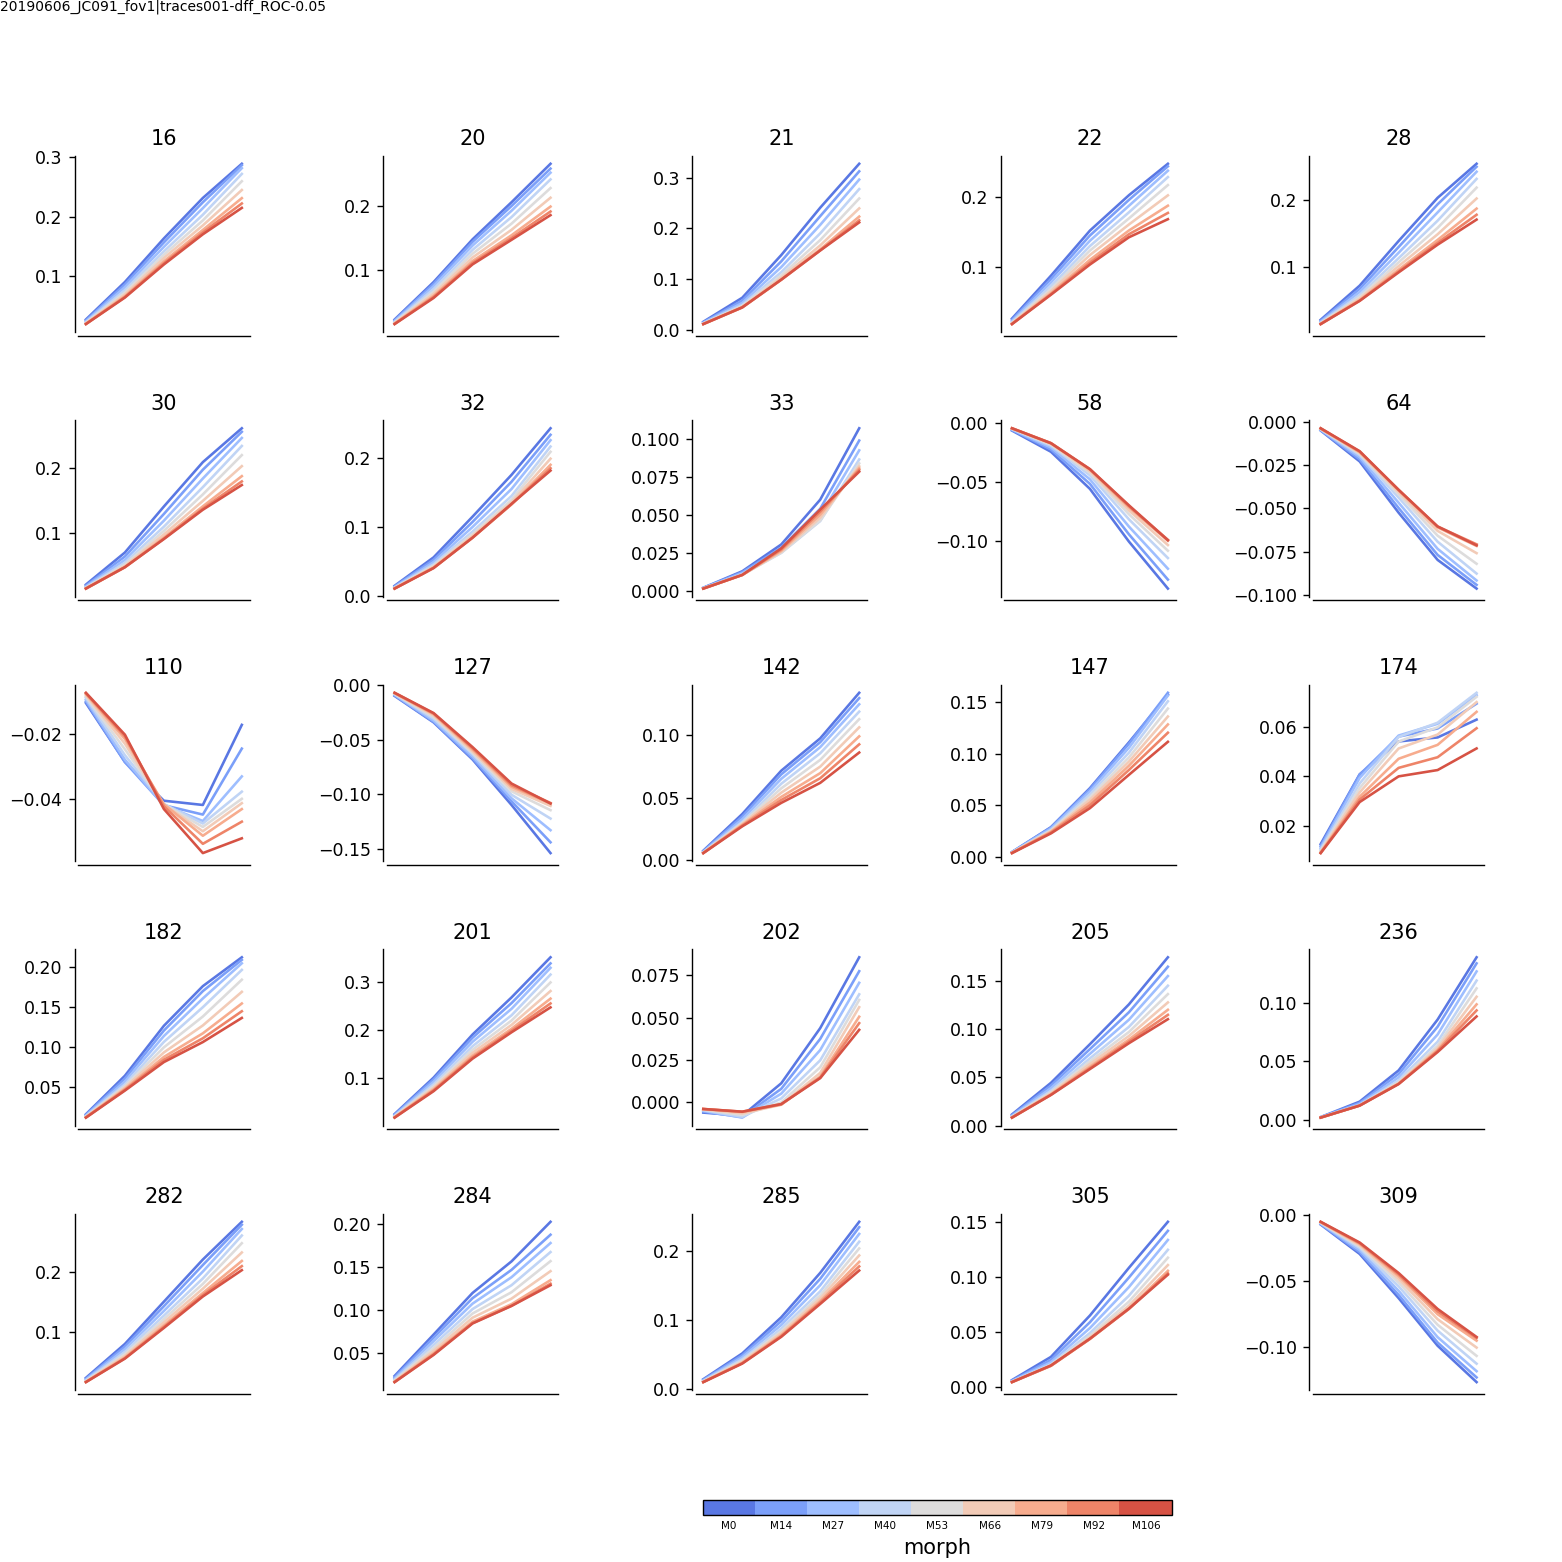

In [172]:
nc=5
nr=5
fig, axes = pl.subplots(nr, nc, sharex=False, sharey=False, figsize=(nc*2.5, nr*2.5))

ai = 0
for rid in roi_list:
    tmpdf = rfdf[rfdf['rid']==rid]
    ax = axes.flat[ai]
    for morph in image_list:
        g = tmpdf[tmpdf['object']==morph]
        ax.plot(g['size'], g['RF_luminance'], color=morph_colors[morph], label=morph)
    #ax.legend()

    if ai==(12*7)-12:
        ax.set_ylabel('RF luminance')
        ax.set_xlabel('size')
        ax.set_xticks(g['size'])
        ax.set_xticklabels([int(s) for s in g['size']])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
    sns.despine(ax=ax, trim=False, offset=2)
    ax.set_title(rid)
    ai += 1
    
pl.subplots_adjust(wspace=0.8, hspace=0.5, top=0.9, left=0.05, right=0.95)
cbar = create_color_bar(fig, morphcolor_list, image_list,
                        cbar_axes=[0.45, 0.03, 0.3, 0.01],  hue_param='morph')
label_figure(fig, data_id)
pl.savefig(os.path.join(outdir, 'roi-rf-lums_%s.svg' % datakey))

# Calculate mutual information metrics

In [52]:
def populate_bins(roi_responses, rkey='dff', n_bins=3):
    bin_labels = ['bin%i' % int(i+1) for i in np.arange(0, n_bins)]
    results, bin_edges = pd.qcut(roi_responses[rkey],
                                q=n_bins,
                                labels=bin_labels,
                                retbins=True)

#     results_table = pd.DataFrame(zip(bin_edges, bin_labels),
#                                 columns=['Threshold', 'Tier'])
    roi_responses['bin'] = results
    
    return roi_responses

In [374]:
def calculate_mutual_information(tmpd, n_bins=3):
    
    # Discretize df/f values
    tmpd = populate_bins(tmpd, n_bins=n_bins)                             
    #tmpd.groupby(['config'])['bin'].value_counts()

    # Convert responses to prob distN
    n_trials_total = float(tmpd.shape[0])
    n_reps_per_cond = float(tmpd.groupby(['config']).count().iloc[0,0])

    # Count occurrences in each state
    state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
    n_per_bin = float(state_counts.groupby(['bin'])['count'].sum().iloc[0])
    state_counts['p(r,s)'] = state_counts['count']/n_trials_total
    p_resp = n_per_bin/n_trials_total # This is uniform (since pd.qcut())
    p_stim = n_reps_per_cond/n_trials_total # This is uniform (since experimental design)

    # Calculate mutual information: 
    mi = np.array([pv*math.log(pv/(p_resp*p_stim), 2) for pv in state_counts['p(r,s)'].values]).sum()
    
    return mi, state_counts


## Test with 1 dataset

In [270]:
datakey = '20190522_JC084_fov1'

In [271]:

session, animalid, fovn = datakey.split('_')
visual_area = dsets[(dsets['animalid']==animalid) \
                    & (dsets['session']==session) \
                    & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

# Blob trial metrics
neuraldata = DATA[datakey]['data'].copy()
trial_key = DATA[datakey]['trial_key'].copy()
blobstats = pd.concat([neuraldata, trial_key], axis=1)
blobstats.index = blobstats['trial']
blobstats.drop('trial', axis=1, inplace=True)

# ROI list for objects
rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
sizes = sorted(DATA[datakey]['sdf']['size'].unique())

# RF fit data
g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

# Get ROIs for both
print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
roi_list = np.intersect1d(rois_objects, rois_rfs)
print("%i rois common to both." % len(roi_list))

# Get RF/screen param info
rfparams = get_rfparams(screen_info, rfstats)


... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 100, RFs: 165
84 rois common to both.


In [ ]:

print("--- calculating RF luminance for each cell's RF ---")
rf_luminances = get_rf_luminances(images, rfstats, rfparams, pix_per_deg=pix_per_deg, sizes=sizes)


In [367]:

# Calculate I(R;S)
print("--- calculating MI for each cell ---")
MI = []; avg_nper = [];
MI_lum= [];
for rid in roi_list:
    tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
    image_configs = [c for c in sdf.index.tolist() if sdf['morphlevel'][c]!=-1]
    tmpd = tmpd[tmpd['config'].isin(image_configs)]
    
    tmprf = rf_luminances[rf_luminances['rid']==rid].copy()

    mi, state_counts, mi_lum = calculate_mutual_information(tmpd, tmprf, n_bins=n_bins)
    MI.append(mi)
    MI_lum.append(mi_lum)
    avg_nper.append(state_counts['count'].mean())


--- calculating MI for each cell ---


<IPython.core.display.Javascript object>


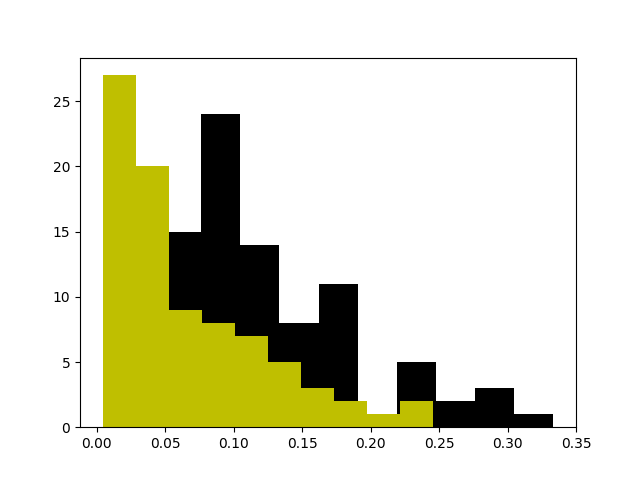

(array([ 27.,  20.,   9.,   8.,   7.,   5.,   3.,   2.,   1.,   2.]),
 array([ 0.00415982,  0.02829074,  0.05242166,  0.07655257,  0.10068349,
         0.12481441,  0.14894533,  0.17307625,  0.19720717,  0.22133809,
         0.245469  ]),
 <a list of 10 Patch objects>)

In [372]:
pl.figure()
pl.hist(MI, color='k')
pl.hist(MI_lum, color='y')

In [352]:
rid

258

In [375]:
def calculate_mutual_information_split(tmpd, tmprf, n_bins=3):
    
    # Discretize df/f values
    tmpd = populate_bins(tmpd, n_bins=n_bins)                             
    #tmpd.groupby(['config'])['bin'].value_counts()

    # Convert responses to prob distN -------------------------
    n_trials_total = float(tmpd.shape[0])
    n_reps_per_cond = float(tmpd.groupby(['config']).count().iloc[0,0])

    # Count occurrences in each state
    state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
    n_per_bin = float(state_counts.groupby(['bin'])['count'].sum().iloc[0])
    state_counts['p(r,s)'] = state_counts['count']/n_trials_total
    p_resp = n_per_bin/n_trials_total # This is uniform (since pd.qcut())
    p_stim = n_reps_per_cond/n_trials_total # This is uniform (since experimental design)

    # Calculate mutual information: 
    mi = np.array([pv*math.log(pv/(p_resp*p_stim), 2) for pv in state_counts['p(r,s)'].values]).sum()

    # Do RF luminance distNs -------------------------
    tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=5)
    
    # For each config, get corresponding RF luminance bin
    rflum_bins = []
    for cfg in tmpd['config']:
        currsz = sdf['size'][cfg]
        currobj = 'M%i' % sdf['morphlevel'][cfg]
        rfbin = tmprf[(tmprf['object']==currobj) & (tmprf['size']==currsz)]['bin'].iloc[0]
        rflum_bins.append(rfbin)
    tmpd['rf_bin'] = rflum_bins
    # Calc. prob (response | luminance value)
    rf_state_counts = tmpd.groupby(['bin', 'rf_bin']).size().reset_index(name='count')
    rf_state_counts['p(r,l)'] = rf_state_counts['count']/n_trials_total
    n_per_rf_bin = float(rf_state_counts.groupby(['rf_bin'])['count'].sum().iloc[0])
    n_per_rf_bin
    p_lum = n_per_rf_bin / n_trials_total

    mi_lum = np.array([pv*math.log(pv/(p_resp*p_lum), 2) for pv in rf_state_counts['p(r,l)'].values]).sum()

    return mi, state_counts, mi_lum


In [354]:
tmprf = rf_luminances[rf_luminances['rid']==rid].copy()
tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=5)


In [355]:
rflum_bins = []
for cfg in tmpd['config']:
    currsz = sdf['size'][cfg]
    currobj = 'M%i' % sdf['morphlevel'][cfg]
    rfbin = tmprf[(tmprf['object']==currobj) & (tmprf['size']==currsz)]['bin'].iloc[0]
    rflum_bins.append(rfbin)
tmpd['rf_bin'] = rflum_bins

In [356]:
tmpd.head()

,dff,config,bin,rf_bin
trial,,,,
1,0.908321,config032,bin3,bin2
2,-0.0239816,config031,bin1,bin1
3,0.0367479,config021,bin2,bin1
4,0.0369167,config020,bin2,bin5
6,0.0361984,config043,bin2,bin3


In [357]:
rf_state_counts = tmpd.groupby(['bin', 'rf_bin']).size().reset_index(name='count')
rf_state_counts['p(r,l)'] = rf_state_counts['count']/n_trials_total

In [358]:
#rf_state_counts
n_per_rf_bin = float(rf_state_counts.groupby(['rf_bin'])['count'].sum().iloc[0])
n_per_rf_bin
p_lum = n_per_rf_bin / n_trials_total
p_lum

0.2076923076923077

In [348]:
n_trials_total

1300.0

In [349]:
1200./270.

4.444444444444445

<IPython.core.display.Javascript object>


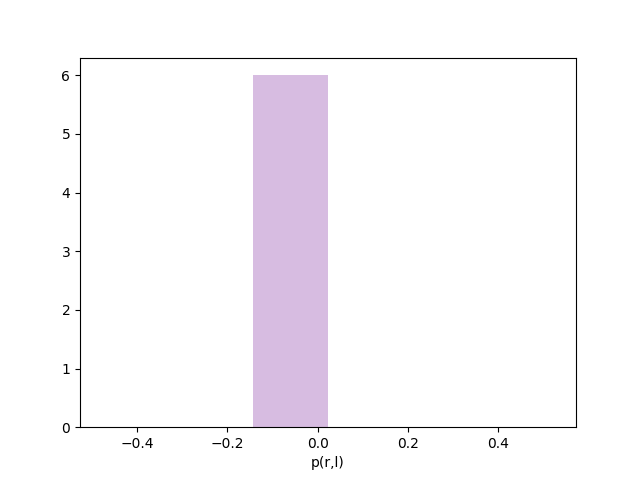

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [336]:
pl.figure()
sns.distplot(rf_state_counts['p(r,l)'])

In [337]:
rf_state_counts

,config,rf_bin,count,"p(r,l)"
0,config006,bin5,30,0.023077
1,config007,bin4,30,0.023077
2,config008,bin2,30,0.023077
3,config009,bin1,30,0.023077
4,config010,bin1,30,0.023077
5,config011,bin5,30,0.023077
6,config012,bin4,30,0.023077
7,config013,bin2,30,0.023077
8,config014,bin1,30,0.023077
9,config015,bin1,30,0.023077


# Calculate for all cells

In [55]:
DATA.keys()[0:5]

['20190512_JC083_fov1',
 '20190420_JC076_fov1',
 '20190603_JC080_fov1',
 '20190506_JC080_fov1',
 '20190510_JC083_fov1']

In [56]:
session, animalid, fovn = datakey.split('_')
dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==int(fovn[3:]))]


,animalid,experiment,fov,session,visual_area,fovnum
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,1
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1


In [57]:
aggr_data_id = data_id.split('|')[-1]
print(aggr_data_id)
print(outdir)

traces001-dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis


# Calculate MI as function of n_bins

In [150]:
mi_dfs = []

for dii, datakey in enumerate(DATA.keys()):

    session, animalid, fovn = datakey.split('_')
    visual_area = dsets[(dsets['animalid']==animalid) \
                        & (dsets['session']==session) \
                        & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

    # Blob trial metrics
    neuraldata = DATA[datakey]['data'].copy()
    trial_key = DATA[datakey]['trial_key'].copy()
    blobstats = pd.concat([neuraldata, trial_key], axis=1)
    blobstats.index = blobstats['trial']
    blobstats.drop('trial', axis=1, inplace=True)

    # ROI list for objects
    rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
    sizes = sorted(DATA[datakey]['sdf']['size'].unique())

    # RF fit data
    g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Get RF/screen param info
    rfparams = get_rfparams(screen_info, rfstats)
    
    # Calculate MI as function of n_bins
    for n_bins in [2, 3, 5, 10, 20]:

        # Calculate MI for all cells
        MI = []; avg_counts=[];
        for rid in roi_list:
            tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
            mi, state_counts = calculate_mutual_information(tmpd, n_bins=n_bins)
            MI.append(mi)
            avg_counts.append((state_counts['count'].mean(), state_counts['count'].std()))

        nsamples = len(MI)
        currdf = pd.DataFrame({'MI': MI,
                               'mean_counts': [val[0] for val in avg_counts],
                               'std_counts': [val[1] for val in avg_counts],
                            'visual_area': [visual_area for _ in np.arange(0, nsamples)],
                            'datakey': [datakey for _ in np.arange(0, nsamples)],
                            'rid': roi_list,
                               'n_bins': [n_bins for _ in np.arange(0, nsamples)]})

        mi_dfs.append(currdf)

mi_dfs = pd.concat(mi_dfs, axis=0)


... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 145
82 rois common to both.
... [JC080|20190506|FOV

... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 152
70 rois common to both.
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 104, RFs: 150
65 rois common to both.
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 90, RFs: 113
69 rois common to both.
... [JC091|201906

<IPython.core.display.Javascript object>


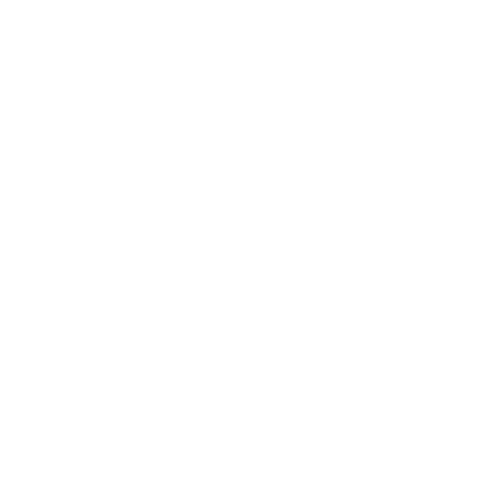

<IPython.core.display.Javascript object>


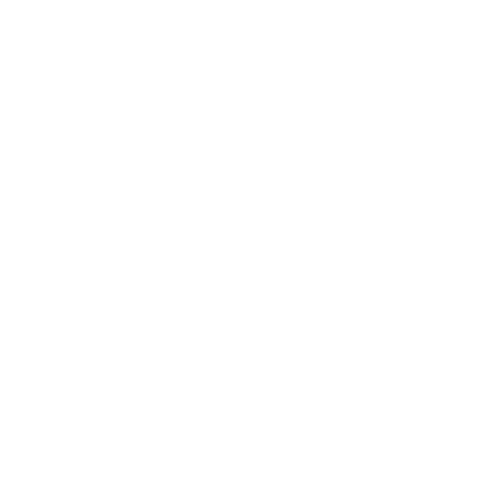

<IPython.core.display.Javascript object>


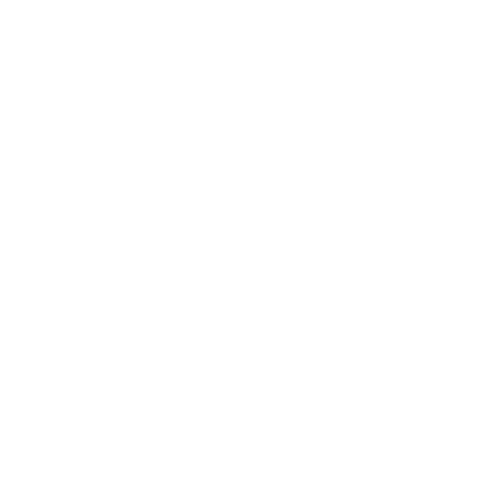

<IPython.core.display.Javascript object>


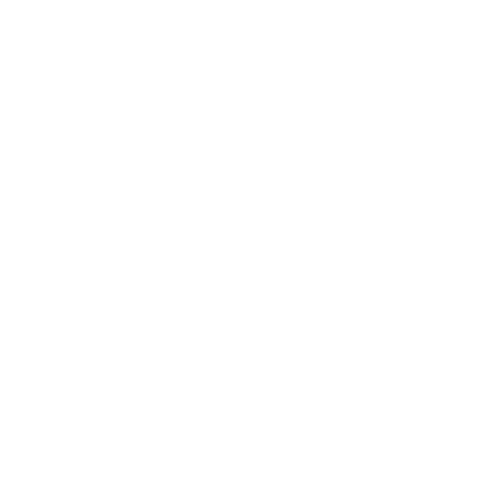

In [118]:
for n_bins, g in mi_dfs.groupby(['n_bins']):
    # Plot
    gplot = sns.catplot(x='visual_area', y='MI', kind='box', data=g, palette='colorblind',
                order=['V1', 'Lm', 'Li'] )
    pl.ylim([0, 0.8])

    label_figure(gplot.fig, aggr_data_id)
    pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells.svg' % n_bins))
    
    pl.close()

,MI,n_bins,rid
visual_area,,,
Li,44.452670,1670,60521
Lm,98.608972,3075,83082
V1,159.813503,4555,141597


<IPython.core.display.Javascript object>


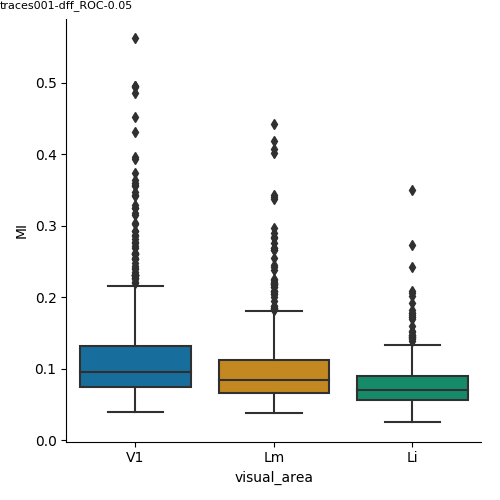

In [77]:
g = sns.catplot(x='visual_area', y='MI', kind='box', data=mi_dfs[mi_dfs['n_bins']==3], palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

label_figure(g.fig, aggr_data_id)
pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells.svg' % n_bins))

In [87]:
visual_areas = ['V1', 'Lm', 'Li']
viscols = sns.color_palette('colorblind', n_colors=3)
area_colors = dict((vis, col) for vis, col in zip(visual_areas, viscols))


In [97]:

bin_clist = sns.color_palette('cubehelix', n_colors=len(mi_dfs['n_bins'].unique()))
bin_colors = dict((n_bins, bcol) for n_bins, bcol in zip(sorted(mi_dfs['n_bins'].unique()), bin_clist))



In [113]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


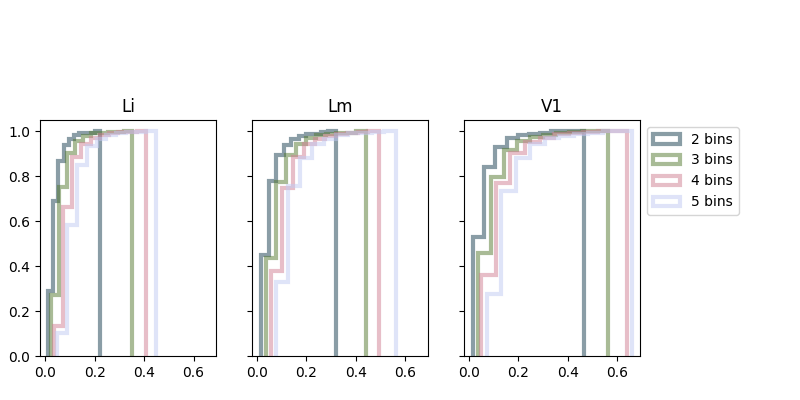

MI-by-nbins_per-area


In [114]:
cdf = True
#kwargs = {'cumulative': True}
fig, axes = pl.subplots(1, 3, sharex=True, sharey=True, figsize=(8,4))
ai = 0
for visual_area, gdf in mi_dfs.groupby(['visual_area']):
    for n_bins, ndf in gdf.groupby(['n_bins']):
        ax = axes[ai]
        values = ndf['MI'].values
        weights = np.ones_like(values)/float(len(values))

        ax.hist(values, 
                cumulative=cdf,
                label='%i bins' % n_bins,
                color=bin_colors[n_bins], #area_colors[visual_area],
                histtype='step', alpha=0.5, lw=3,
                normed=0, weights=weights)
    ax.set_title(visual_area)
    ai += 1
pl.subplots_adjust(left=0.05, right=0.8, top=0.7)
ax.legend(bbox_to_anchor=(1.0, 1))

figname = 'MI-by-nbins_per-area'
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print figname

# Plot average MI and n trials per bin as a function of N_BINS

In [152]:
ndf

,MI,datakey,mean_counts,n_bins,rid,std_counts,visual_area
0,0.076271,20190512_JC083_fov1,15.500000,2,4,4.900010,Lm
1,0.027922,20190512_JC083_fov1,15.500000,2,6,3.036811,Lm
2,0.024925,20190512_JC083_fov1,15.500000,2,9,2.872721,Lm
3,0.104948,20190512_JC083_fov1,15.500000,2,11,5.791844,Lm
4,0.054505,20190512_JC083_fov1,15.500000,2,13,4.198364,Lm
5,0.039264,20190512_JC083_fov1,15.500000,2,20,3.574602,Lm
6,0.040806,20190512_JC083_fov1,15.500000,2,25,3.652867,Lm
7,0.095834,20190512_JC083_fov1,15.656566,2,28,5.157047,Lm
8,0.044543,20190512_JC083_fov1,15.500000,2,29,3.820466,Lm
9,0.038400,20190512_JC083_fov1,15.500000,2,35,3.551924,Lm


<IPython.core.display.Javascript object>


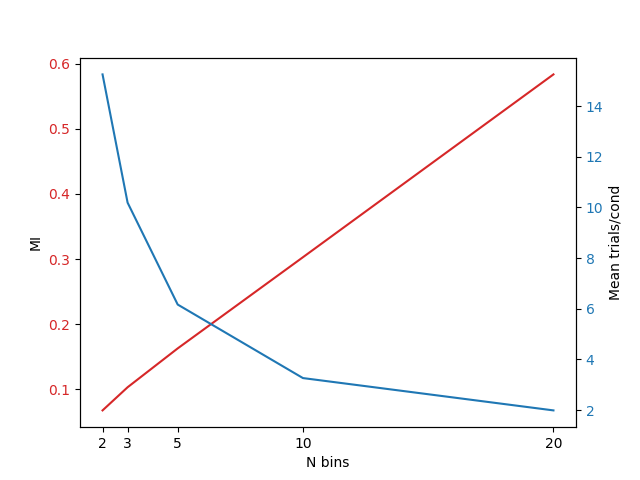

In [434]:
col1 = 'tab:red'
col2 = 'tab:blue'

fig, ax = pl.subplots() #pl.figure()
xv = [n_bins for n_bins, ndf in mi_dfs.groupby(['n_bins'])]
yv = [ndf['MI'].mean() for n_bins, ndf in mi_dfs.groupby(['n_bins'])]
ax.plot(xv, yv, color=col1)
ax.tick_params(axis='y', labelcolor=col1)
ax.set_ylabel('MI')

ax2 = ax.twinx()
yv2 = [ndf['mean_counts'].mean() for n_bins, ndf in mi_dfs.groupby(['n_bins'])]
ax2.plot(xv, yv2, color=col2)
ax2.tick_params(axis='y', labelcolor=col2)
ax2.set_ylabel("Mean trials/cond")

ax.set_xlabel('N bins')
ax.set_xticks(xv)
ax.set_xticklabels(xv)

pl.savefig(os.path.join(outdir, 'MI-vs-nreps_by-nbins.svg'))

# Choose N bins

In [441]:
import scikit_posthocs as sp


In [ ]:
n_bins = 3
mdf = []
for dii, datakey in enumerate(DATA.keys()):

    session, animalid, fovn = datakey.split('_')
    visual_area = dsets[(dsets['animalid']==animalid) \
                        & (dsets['session']==session) \
                        & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

    # Blob trial metrics
    neuraldata = DATA[datakey]['data'].copy()
    trial_key = DATA[datakey]['trial_key'].copy()
    blobstats = pd.concat([neuraldata, trial_key], axis=1)
    blobstats.index = blobstats['trial']
    blobstats.drop('trial', axis=1, inplace=True)

    # ROI list for objects
    rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
    sizes = sorted(DATA[datakey]['sdf']['size'].unique())

    # RF fit data
    g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Get RF/screen param info
    rfparams = get_rfparams(screen_info, rfstats)

    print("--- calculating RF luminance for each cell's RF ---")
    rf_luminances = get_rf_luminances(images, rfstats, rfparams, roi_list=roi_list, 
                                      pix_per_deg=pix_per_deg, sizes=sizes)
    

In [497]:
rf_luminances.groupby(['rid']).count()

,RF_luminance,object,size
rid,,,
0,45,45,45
4,45,45,45
6,45,45,45
11,45,45,45
24,45,45,45
82,45,45,45
84,45,45,45
99,45,45,45
107,45,45,45


In [382]:
n_bins = 3
mdf = []
for dii, datakey in enumerate(DATA.keys()):

    session, animalid, fovn = datakey.split('_')
    visual_area = dsets[(dsets['animalid']==animalid) \
                        & (dsets['session']==session) \
                        & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

    # Blob trial metrics
    neuraldata = DATA[datakey]['data'].copy()
    trial_key = DATA[datakey]['trial_key'].copy()
    blobstats = pd.concat([neuraldata, trial_key], axis=1)
    blobstats.index = blobstats['trial']
    blobstats.drop('trial', axis=1, inplace=True)

    # ROI list for objects
    rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
    sizes = sorted(DATA[datakey]['sdf']['size'].unique())

    # RF fit data
    g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Get RF/screen param info
    rfparams = get_rfparams(screen_info, rfstats)

    print("--- calculating RF luminance for each cell's RF ---")
    rf_luminances = get_rf_luminances(images, rfstats, rfparams, roi_list=roi_list, 
                                      pix_per_deg=pix_per_deg, sizes=sizes)

    # Calculate MI for all cells
    print("--- calculating MI for each cell ---")
    MI = []; avg_counts=[];
    MI_lum = [];
    for rid in roi_list:
        tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
    
        # Only get image-trials
        image_configs = [c for c in sdf.index.tolist() if sdf['morphlevel'][c]!=-1]
        tmpd = tmpd[tmpd['config'].isin(image_configs)]
        
        # Get RF info
        tmprf = rf_luminances[rf_luminances['rid']==rid].copy()

        mi, state_counts, mi_lum = calculate_mutual_information_split(tmpd, tmprf, n_bins=n_bins)
        MI.append(mi)
        MI_lum.append(mi_lum)
        avg_counts.append( (state_counts['count'].mean(), state_counts['count'].std()) )


    nsamples = len(MI)
    currdf = pd.DataFrame({'MI': MI,
                           'MI_lum': MI_lum,
                           'mean_counts': [val[0] for val in avg_counts],
                           'std_counts': [val[1] for val in avg_counts],
                        'visual_area': [visual_area for _ in np.arange(0, nsamples)],
                        'datakey': [datakey for _ in np.arange(0, nsamples)],
                        'rid': roi_list})

    mdf.append(currdf)

mdf = pd.concat(mdf, axis=0)


... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_stati

--- calculating MI for each cell ---
... [JC097|20190616|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 188, RFs: 181
126 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC083|20190508|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 131
86 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... re

In [384]:
with open(os.path.join(outdir, 'mutual-information.pkl'), 'wb') as f:
    pkl.dump(mdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [477]:
mdf['MI_nonlum'] = mdf['MI'] - mdf['MI_lum']
mdf['f_high'] = mdf['MI_nonlum'] / mdf['MI']
mdf['f_low'] = mdf['MI_lum'] / mdf['MI']


In [397]:
std

[0.037723403581616542, 0.052870329396294644, 0.06281848890762104]

<IPython.core.display.Javascript object>


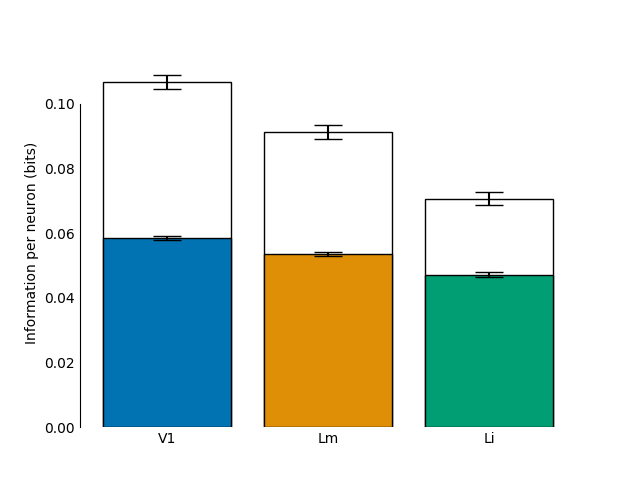

In [490]:
fig, ax = pl.subplots()

# Plot mutual info
means = [mdf[mdf['visual_area']==vis]['MI'].mean() for vis in visual_areas]
std = [spstats.sem(mdf[mdf['visual_area']==vis]['MI']) for vis in visual_areas]
#std = [mdf[mdf['visual_area']==vis]['MI'].std() for vis in visual_areas]
positions=[0, 1, 2]
bars = ax.bar(positions, means, yerr=std, align='center', alpha=1.0, ecolor='black', capsize=10, 
             color='w', linewidth=1, edgecolor='k')
# for bar, visual_area in zip(bars, visual_areas):
#     bar.set_color('w')
#     bar.set_alpha(1)

means_non = [mdf[mdf['visual_area']==vis]['MI_nonlum'].mean() for vis in visual_areas]
std_non = [spstats.sem(mdf[mdf['visual_area']==vis]['MI_nonlum']) for vis in visual_areas]
#std_non = [mdf[mdf['visual_area']==vis]['MI_nonlum'].std() for vis in visual_areas]
positions=[0, 1, 2]
bars = ax.bar(positions, means_non, yerr=std_non, align='center', alpha=0.5, 
              ecolor='k', capsize=10,
             linewidth=1, edgecolor='k')
for bar, visual_area in zip(bars, visual_areas):
    bar.set_color(area_colors[visual_area])
    bar.set_alpha(1)
    bar.set_linewidth(1)
    bar.set_edgecolor('k')
    
ax.set_xticks(positions) #(visual_areas)
ax.set_xticklabels(visual_areas)
ax.tick_params(axis='both', length=0)
ax.set_ylabel('Information per neuron (bits)')
label_figure(g.fig, aggr_data_id)

sns.despine(trim=True, bottom=True)

pl.savefig(os.path.join(outdir, 'MI_split.svg'))
pl.savefig(os.path.join(outdir, 'MI_split.png'))


# F_high

In [487]:
def calculate_stats_by_area(mdf, metric='MI'):

    g= sns.catplot(x='visual_area', y=metric, kind='bar', data=mdf, palette='colorblind',
               order=['V1', 'Lm', 'Li'] )

    
    c1 = mdf[mdf['visual_area']=='V1'][metric]
    c2 = mdf[mdf['visual_area']=='Lm'][metric]
    c3 = mdf[mdf['visual_area']=='Li'][metric]
    print(c1.shape, c2.shape, c3.shape)

    # Shapiro-Wilk normality test 
    print("Shapiro-Wilk normality:", spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

    F, p = spstats.f_oneway(c1, c2, c3)
    print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

    scores = np.hstack([c1, c2, c3])
    groups = np.hstack([['V1' for _ in range(len(c1))], 
                       ['Lm' for _ in range(len(c2))],
                       ['Li' for _ in range(len(c3))]])
    # Note that data in sheet have been preformatted in Group and Score columns 
    # Boolean values refer to whether we should reject the null hypothesis (H0) that
    # the means of the tested pair are statistically similar (non-significant differences)
    mcobj = ml.MultiComparison(scores, groups)
    out = mcobj.tukeyhsd(0.05) 
    print(out)

    print(spstats.kruskal(c1, c2, c3))
    statsdf = mdf[['visual_area', metric]].copy()
    print(sp.posthoc_dunn(statsdf, val_col=metric, group_col='visual_area', p_adjust='bonferroni')) #'fdr_by')
    
    return g

In [484]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


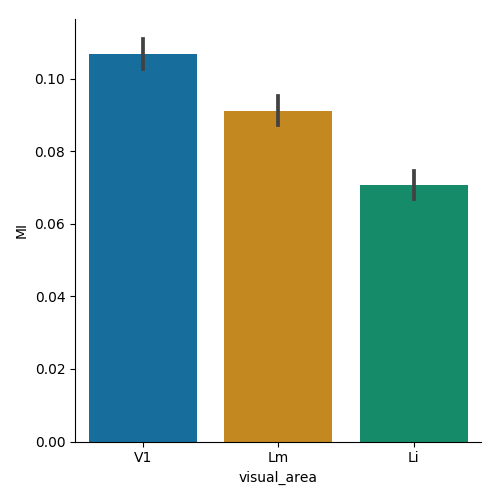

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7505552172660828, 6.627801622061434e-35), (0.7290875911712646, 2.077272679146e-30), (0.7476382255554199, 3.093683511287677e-22))
F statistic = 53.345 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0205  0.0116 0.0294  True 
  Li     V1    0.0361  0.0277 0.0444  True 
  Lm     V1    0.0156  0.0087 0.0224  True 
-------------------------------------------
KruskalResult(statistic=183.61651431948667, pvalue=1.343323221736018e-40)
              Li            Lm            V1
Li -1.000000e+00  4.006227e-13  4.800194e-40
Lm  4.006227e-13 -1.000000e+00  6.512182e-11
V1  4.800194e-40  6.512182e-11 -1.000000e+00


In [493]:
metric='MI'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))


<IPython.core.display.Javascript object>


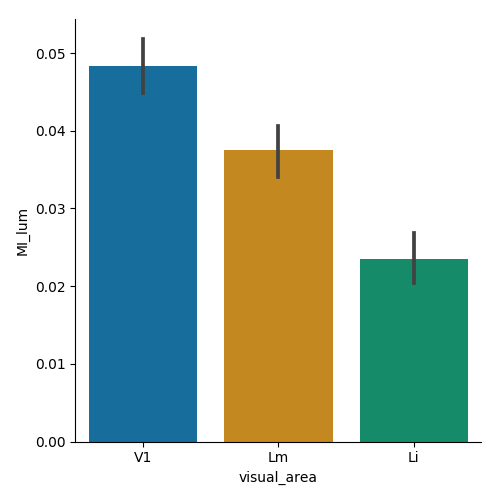

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7094955444335938, 5.9523746322497905e-37), (0.6896823644638062, 4.472202053165979e-32), (0.6138126254081726, 1.0781328865660525e-26))
F statistic = 34.365 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0141  0.0065 0.0217  True 
  Li     V1    0.0248  0.0176 0.032   True 
  Lm     V1    0.0107  0.0049 0.0166  True 
-------------------------------------------
KruskalResult(statistic=129.33353598052236, pvalue=8.2334053884913261e-29)
              Li            Lm            V1
Li -1.000000e+00  5.372132e-09  2.381671e-28
Lm  5.372132e-09 -1.000000e+00  1.764815e-08
V1  2.381671e-28  1.764815e-08 -1.000000e+00


In [494]:
metric='MI_lum'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))


<IPython.core.display.Javascript object>


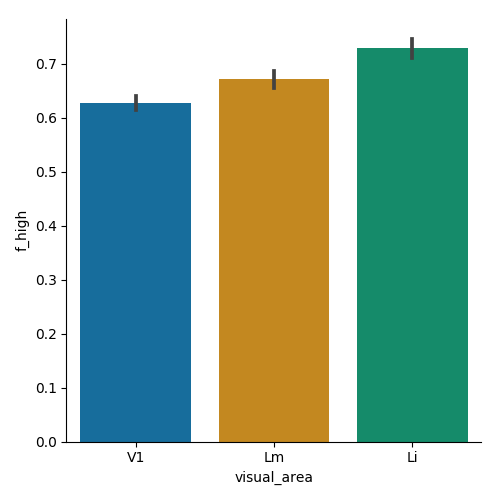

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.9692666530609131, 6.074017699399248e-13), (0.9419101476669312, 8.945549684303503e-15), (0.9164955615997314, 1.1338407426494945e-12))
F statistic = 35.856 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Li     Lm   -0.0575  -0.0877 -0.0272  True 
  Li     V1   -0.1006  -0.1291 -0.0722  True 
  Lm     V1   -0.0432  -0.0664 -0.0199  True 
---------------------------------------------
KruskalResult(statistic=75.377356179395974, pvalue=4.2856339661552985e-17)
              Li        Lm            V1
Li -1.000000e+00  0.000035  8.576046e-17
Lm  3.536996e-05 -1.000000  9.803982e-06
V1  8.576046e-17  0.000010 -1.000000e+00


In [491]:
metric='f_high'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))

## Stats, f_low

<IPython.core.display.Javascript object>


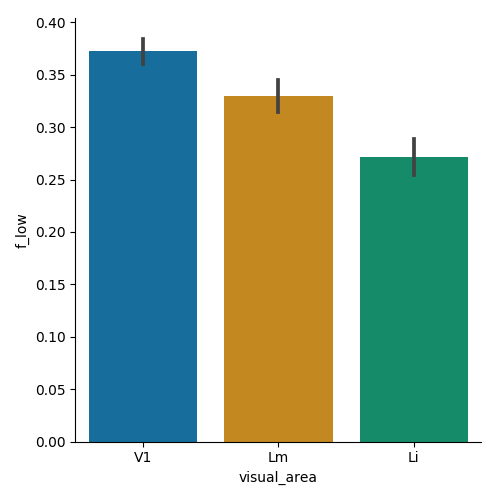

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.9692655801773071, 6.070160650170631e-13), (0.9419098496437073, 8.944685710697304e-15), (0.9164948463439941, 1.1336860269994808e-12))
F statistic = 35.856 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0575  0.0272 0.0877  True 
  Li     V1    0.1006  0.0722 0.1291  True 
  Lm     V1    0.0432  0.0199 0.0664  True 
-------------------------------------------
KruskalResult(statistic=75.377356179395974, pvalue=4.2856339661552985e-17)
              Li        Lm            V1
Li -1.000000e+00  0.000035  8.576046e-17
Lm  3.536996e-05 -1.000000  9.803982e-06
V1  8.576046e-17  0.000010 -1.000000e+00


In [488]:
metric='f_low'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))

#### Stats, I(R; S'|L)

<IPython.core.display.Javascript object>


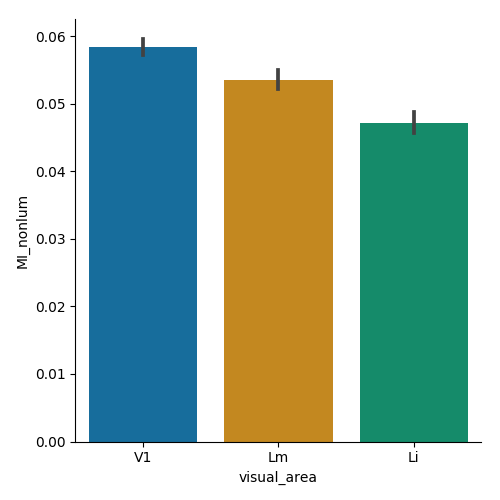

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7615834474563599, 2.6120568134125893e-34), (0.6906959414482117, 4.911658852979365e-32), (0.908942461013794, 2.5755463842376536e-13))
F statistic = 48.456 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0064  0.0035 0.0093  True 
  Li     V1    0.0112  0.0085 0.014   True 
  Lm     V1    0.0048  0.0026 0.0071  True 
-------------------------------------------
KruskalResult(statistic=122.5305421858402, pvalue=2.4707615375522554e-27)
              Li            Lm            V1
Li -1.000000e+00  1.827142e-07  2.211404e-26
Lm  1.827142e-07 -1.000000e+00  3.236547e-09
V1  2.211404e-26  3.236547e-09 -1.000000e+00


In [492]:
metric='MI_nonlum'
g = calculate_stats_by_area(mdf, metric=metric)

pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))

## Stats - I(R; L)

<IPython.core.display.Javascript object>


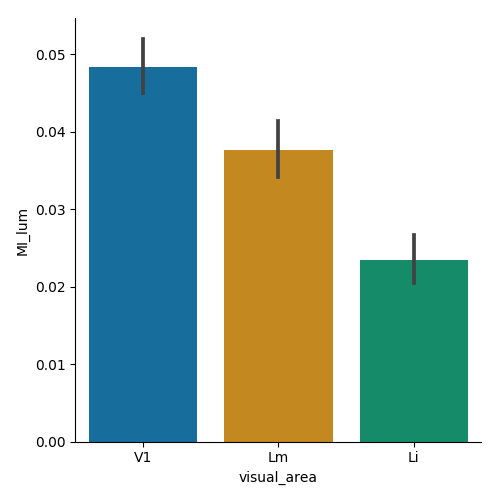

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7094955444335938, 5.9523746322497905e-37), (0.6896823644638062, 4.472202053165979e-32), (0.6138126254081726, 1.0781328865660525e-26))
F statistic = 34.365 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0141  0.0065 0.0217  True 
  Li     V1    0.0248  0.0176 0.032   True 
  Lm     V1    0.0107  0.0049 0.0166  True 
-------------------------------------------
KruskalResult(statistic=129.33353598052236, pvalue=8.2334053884913261e-29)
              Li        Lm            V1
Li -1.000000e+00  0.000035  8.576046e-17
Lm  3.536996e-05 -1.000000  9.803982e-06
V1  8.576046e-17  0.000010 -1.000000e+00


In [476]:
metric='MI_lum'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))

<IPython.core.display.Javascript object>


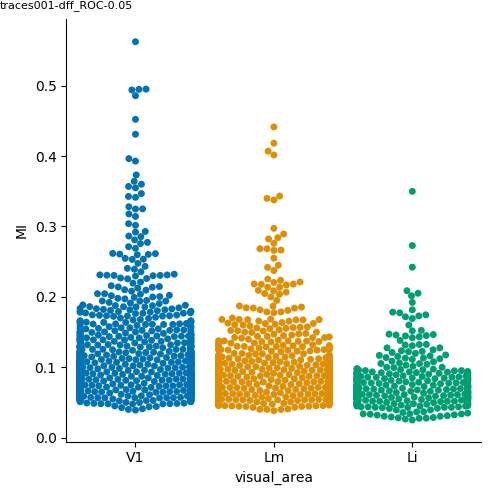

In [230]:

# Plot
g = sns.catplot(x='visual_area', y='MI', kind='swarm', data=mdf, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )
#pl.ylim([0, 1.0])

label_figure(g.fig, aggr_data_id)

pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells_swarm.svg' % n_bins))


#### stats

In [236]:
mdf.groupby(['visual_area']).count()

,MI,datakey,mean_counts,rid,std_counts
visual_area,,,,,
Li,334,334,334,334,334
Lm,615,615,615,615,615
V1,911,911,911,911,911


In [245]:
min_n = 334
r1 = np.arange(0, 911)
np.random.shuffle(r1)
r2 = np.arange(0, 615)
np.random.shuffle(r2)

c1 = mdf[mdf['visual_area']=='V1']['MI'].values[r1[0:min_n]]
c2 = mdf[mdf['visual_area']=='Lm']['MI'].values[r2[0:min_n]]
c3 = mdf[mdf['visual_area']=='Li']['MI'].values
print(c1.shape, c2.shape, c3.shape)

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
#print(scores.shape)
#print(groups.shape)


# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((334,), (334,), (334,))
F statistic = 37.188 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0225  0.0122 0.0329  True 
  Li     V1    0.0379  0.0275 0.0483  True 
  Lm     V1    0.0153  0.005  0.0257  True 
-------------------------------------------


In [246]:
df1 = pd.DataFrame({'MI': mdf[mdf['visual_area']=='V1']['MI'].values[r1[0:min_n]],
                        'visual_area': ['V1' for _ in np.arange(0, min_n)]})
df2 = pd.DataFrame({'MI': mdf[mdf['visual_area']=='Lm']['MI'].values[r2[0:min_n]],
                        'visual_area': ['Lm' for _ in np.arange(0, min_n)]})
df3 = pd.DataFrame({'MI': mdf[mdf['visual_area']=='Li']['MI'].values,
                        'visual_area': ['Li' for _ in np.arange(0, min_n)]})
tmp_mdf = pd.concat([df1, df2, df3])

<IPython.core.display.Javascript object>


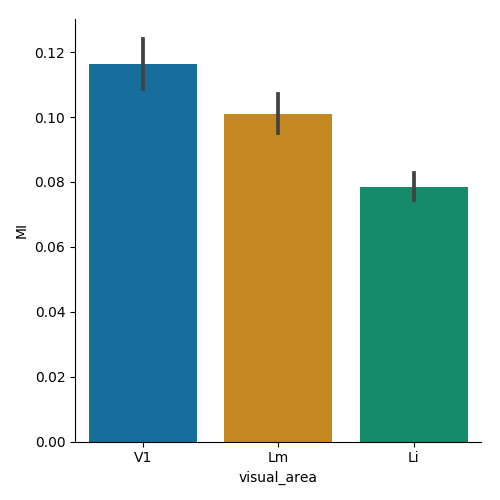

In [247]:

# Plot
g = sns.catplot(x='visual_area', y='MI', kind='bar', data=tmp_mdf, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

pl.savefig(os.path.join(outdir, 'MI-avg-by-session_random-match-nsamples.svg'))

# Average by session

In [231]:
mean_by_session = []
for vi, m in mdf.groupby(['visual_area']):
    vals = m.groupby(['datakey'])['MI'].mean()
    mean_by_session.append(pd.DataFrame({'MI': vals,
                                         'visual_area': [vi for _ in np.arange(0, len(vals))]}))
    
mean_by_session = pd.concat(mean_by_session, axis=0)

In [232]:
mean_by_session.groupby(['visual_area']).count()

,MI
visual_area,
Li,13
Lm,11
V1,11


#### stats

In [233]:
import statsmodels.stats.multicomp as ml
import scipy.stats as spstats

In [234]:
c1 = mean_by_session[mean_by_session['visual_area']=='V1']['MI'].values
c2 = mean_by_session[mean_by_session['visual_area']=='Lm']['MI'].values
c3 = mean_by_session[mean_by_session['visual_area']=='Li']['MI'].values
print(c1.shape, c2.shape, c3.shape)

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
#print(scores.shape)
#print(groups.shape)


# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((11,), (11,), (13,))
F statistic = 8.327 and probability p = 0.001
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.0187  -0.0036 0.041  False 
  Li     V1    0.037    0.0147 0.0594  True 
  Lm     V1    0.0183  -0.0049 0.0416 False 
--------------------------------------------


In [222]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


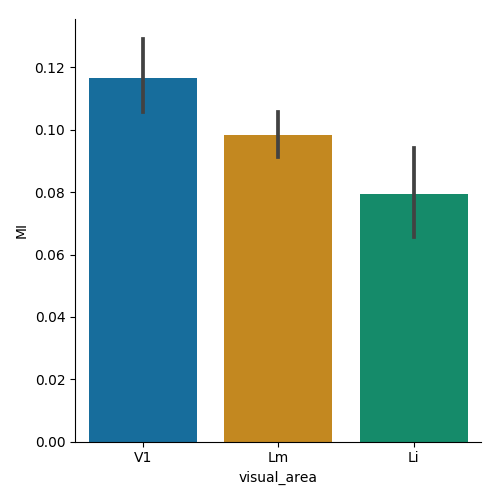

In [235]:

# Plot
g = sns.catplot(x='visual_area', y='MI', kind='bar', data=mean_by_session, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

pl.savefig(os.path.join(outdir, 'MI-avg-by-session_bar.svg'))

# MI of Luminance

In [248]:
mdf.head()

,MI,datakey,mean_counts,rid,std_counts,visual_area
0,0.103257,20190512_JC083_fov1,10.333333,4,3.902618,Lm
1,0.050756,20190512_JC083_fov1,10.333333,6,2.753074,Lm
2,0.039986,20190512_JC083_fov1,10.333333,9,2.448576,Lm
3,0.144819,20190512_JC083_fov1,10.333333,11,4.563742,Lm
4,0.060805,20190512_JC083_fov1,10.333333,13,2.953025,Lm
